For P4 we decided that we needed more data to train and test a model so we downloaded and parsed each match up from the regular season and used that data to predict the outcome of games. The first plot is using the the entire regular season to train and test data with diffrent sizes. The second plot is still using differnt train sizes but is testing using the 2024 playoff results. We also added in the data that we collected and parsed from the previous assignments to see which prediction tool was better. 

In [7]:
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import pickle
from sklearn.metrics import roc_auc_score
import operator
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
import random

In [60]:
#Fixing abrreviations to match data 
name_to_abbrev = {
    'Arizona Cardinals':'crd','Atlanta Falcons':'atl','Baltimore Ravens':'rav','Buffalo Bills':'buf','Carolina Panthers':'car','Chicago Bears':'chi','Cincinnati Bengals':'cin',
    'Cleveland Browns':'cle','Dallas Cowboys':'dal','Denver Broncos':'den','Detroit Lions':'det','Green Bay Packers':'gnb','Houston Texans':'htx','Indianapolis Colts':'clt',
    'Jacksonville Jaguars':'jax','Kansas City Chiefs':'kan','Las Vegas Raiders':'rai','Los Angeles Chargers':'sdg','Los Angeles Rams':'ram','Miami Dolphins':'mia',
    'Minnesota Vikings':'min','New England Patriots':'nwe','New Orleans Saints':'nor','New York Giants':'nyg','New York Jets':'nyj','Philadelphia Eagles':'phi',
    'Pittsburgh Steelers':'pit', 'San Francisco 49ers':'sfo','Seattle Seahawks': 'sea','Tampa Bay Buccaneers':'tam', 'Tennessee Titans': 'oti', 'Washington Commanders': 'was'
}

# Index the team stats by abbreviation
stats = df2.set_index('Team')

turnovers_score = {}
offplays_score  = {}

for full_name, abbr in name_to_abbrev.items():
    row = stats.loc[abbr]
    # Fewer turnovers is better so use negative so a higher score = better
    turnovers_score[full_name] = -row['Turnovers']
    # More offensive plays is better
    offplays_score[full_name]  =  row['Avg Offensive Plays']


In [67]:
# Load CSV into a new DataFrame
df1 = pd.read_csv('nfl_week_results.csv')
df2 = pd.read_csv('nfl_team_stats.csv')
df3 = pd.read_csv('Playoffs.csv')

results_nfl = {'NFL_2024': []}


for _, row in df1.iterrows():
    home = row['Home']
    away = row['Away']
    winner = row['Winner']
    loser = away if winner == home else home  
 
    #store to match functions
    results_nfl['NFL_2024'].append(f"{winner} --> {loser}")


playoff_pairs = []

for _, row in df3.iterrows():
    home   = row['Home']
    away   = row['Away']
    winner = row['Winner']
    loser  = away if winner == home else home
    playoff_pairs.append([winner, loser])


for _, row in df.iterrows():
    home = row['Home']
    away = row['Away']
    winner = row['Winner']
    loser = away if winner == home else home
    G.add_edge(loser, winner)

pr = nx.pagerank(G)
ranking = sorted(pr.items(), key=lambda x: x[1], reverse=True)




In [72]:
def perform_test(results, frac):
    train, test, set_of_players = split_training_and_testing(results, frac)

    pagerank, wins, frac_wins = build_network_and_compute_scores(train, set_of_players)

    auc_pagerank = compute_roc_auc_score(test, pagerank)

    auc_turnovers = compute_roc_auc_score(test, turnovers_score)

    auc_offplays  = compute_roc_auc_score(test, offplays_score)

    return auc_pagerank, auc_turnovers, auc_offplays

def average_over_multiple_realizations(results, frac, T):
    vec_auc_pagerank = []

    for _ in range(T):
        auc_pagerank, _, _ = perform_test(results, frac)
        vec_auc_pagerank.append(auc_pagerank)

    return np.mean(vec_auc_pagerank)

def sample_training_from_regular(results, frac):
    train = []
    set_of_players = set()
    for r in results:
        for q in results[r]:
            p1, p2 = [s.strip() for s in q.split(' --> ')]
            if random.random() < frac:
                train.append([p1, p2])
            set_of_players.add(p1)
            set_of_players.add(p2)
    return train, set_of_players


def average_playoff_auc(results, playoff_pairs, frac, T):
    vec_auc_pagerank  = []
    vec_auc_turnovers = []
    vec_auc_offplays  = []

    for _ in range(T):
        train, set_of_players = sample_training_from_regular(results, frac)
        pagerank, wins, frac_wins = build_network_and_compute_scores(train, set_of_players)

        auc_pg  = compute_roc_auc_score(playoff_pairs, pagerank)
        auc_to  = compute_roc_auc_score(playoff_pairs, turnovers_score)
        auc_off = compute_roc_auc_score(playoff_pairs, offplays_score)

        vec_auc_pagerank.append(auc_pg)
        vec_auc_turnovers.append(auc_to)
        vec_auc_offplays.append(auc_off)

    return (np.mean(vec_auc_pagerank),
            np.mean(vec_auc_turnovers),
            np.mean(vec_auc_offplays))


In [73]:
T = 100
x = []
y = []

for f in np.linspace(0, 1, 10):
    if f < 1.0:
        auc_pg = average_over_multiple_realizations(results_nfl, f, T)
        x.append(f)
        y.append(auc_pg)

x = np.array(x)
y = np.array(y)


In [74]:
T = 100
x_playoff = []
y_playoff = []

for f in np.linspace(0, 1, 10):
    if 0.0 < f < 1.0:
        auc_pg, auc_to, auc_off = average_playoff_auc(results_nfl, playoff_pairs, f, T)
        x_playoff.append(f)
        y_playoff.append([auc_pg, auc_to, auc_off])

x_playoff = np.array(x_playoff)
y_playoff = np.array(y_playoff)

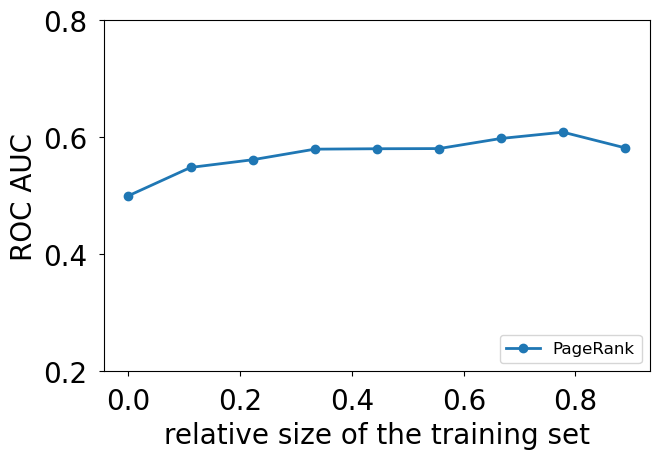

In [77]:
fig = plt.figure()
fig.set_size_inches(7, 5)

ax1 = fig.add_subplot(1, 1, 1)

ax1.set_xlabel('relative size of the training set')
ax1.set_ylabel('ROC AUC')

# Only PageRank is plotted
ax1.plot(x, y, marker='o', linewidth=2, label='PageRank')

ax1.set_ylim(0.2, 0.8)

ax1.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()


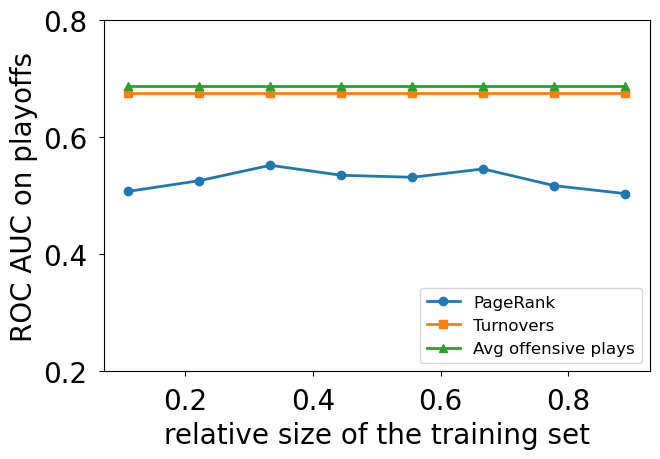

In [76]:
fig = plt.figure()
fig.set_size_inches(7, 5)
ax1 = fig.add_subplot(1, 1, 1)

ax1.set_xlabel('relative size of the training set')
ax1.set_ylabel('ROC AUC on playoffs')

ax1.plot(x_playoff, y_playoff[:, 0], marker='o', linewidth=2, label='PageRank')
ax1.plot(x_playoff, y_playoff[:, 1], marker='s', linewidth=2, label='Turnovers')
ax1.plot(x_playoff, y_playoff[:, 2], marker='^', linewidth=2, label='Avg offensive plays')
ax1.set_ylim(0.2, 0.8)
ax1.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()